# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

In [40]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, mean_squared_error, classification_report

pd.set_option('display.max_columns', None)

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [41]:
# Read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Cleaning

In [119]:
from data.data_cleaning import *

# save the cleaned portfolio dataset to portfolio_clean
portfolio_clean = clean_portfolio(portfolio)
display(portfolio_clean.head())

# Apply the function to clean the profile data
profile_clean = clean_profile(profile)
display(profile_clean.head())

# save the cleaned transcript dataset to transcript_clean
transcript_clean = clean_transcript(transcript)
display(transcript_clean.head())

c:\Users\casas\Downloads\udacity-starbucks\data\data_cleaning.py:10: FutureWarning:

The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.



,reward,difficulty,duration,offer_id,channel_email,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,True,False,False
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,True,False,False
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,False,False,True
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,True,False,False
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,False,True,False


Data type of 'became_member_on' after conversion: datetime64[ns]


,age,customer_id,income,gender_F,gender_M,gender_O,member_tenure
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,True,False,False,2354
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,True,False,False,2421
5,68,e2127556f4f64592b11af22de27a7932,70000.0,False,True,False,2069
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,False,True,False,2145
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,False,True,False,2235


,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,False,True,False,False,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,False,True,False,False,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,False,True,False,False,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,False,True,False,False,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,False,True,False,False,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


# Analysis

## 1. How many customers received offers in this dataset? What kind of offers did they recieve?

In [45]:
# Count how many unique customers received at least 1 offer
customer_offer_received = transcript_clean[transcript_clean.event_offer_received == 1]['customer_id'].nunique(
)
print("{} customers received at least 1 offer.".format(customer_offer_received))

16994 customers received at least 1 offer.


In [46]:
# Define a function to get a new column for offer type
def offer_type(row):
    for offer in ['bogo', 'discount', 'informational']:
        if row[f'offer_type_{offer}'] == 1:
            return offer


# Merge transcript_clean & portfolio_clean dataset to get offer_type data
transcript_df = pd.merge(
    transcript_clean, portfolio_clean, on='offer_id', how='left')

# Apply the function to get the offer type
transcript_df['offer_type'] = transcript_df.apply(offer_type, axis=1)

transcript_df.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,reward,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount,offer_type_informational,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,0,False,True,False,False,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,1.0,1.0,0.0,1.0,True,False,False,bogo
1,a03223e636434f42ac4c3df47e8bac43,0,False,True,False,False,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,20.0,10.0,1.0,0.0,0.0,1.0,False,True,False,discount
2,e2127556f4f64592b11af22de27a7932,0,False,True,False,False,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,7.0,1.0,1.0,0.0,1.0,False,True,False,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,False,True,False,False,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,10.0,10.0,1.0,1.0,1.0,1.0,False,True,False,discount
4,68617ca6246f4fbc85e91a2a49552598,0,False,True,False,False,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0,10.0,5.0,1.0,1.0,1.0,1.0,True,False,False,bogo


In [47]:
# Get the breakdown of offer type
offer_breakdown = (transcript_df[transcript_df.event_offer_received == 1]
                   .groupby(['offer_type', 'offer_id'])['customer_id']
                   .nunique()
                   .reset_index()
                   .rename(columns={'customer_id': 'count'}))

offer_breakdown

,offer_type,offer_id,count
0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,6330
1,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,6355
2,bogo,ae264e3637204a6fb9bb56bc8210ddfd,6374
3,bogo,f19421c1d4aa40978ebb69ca19b0e20d,6262
4,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,6374
5,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,6325
6,discount,2906b810c7d4411798c6938adc9daaa5,6285
7,discount,fafdcd668e3743c1bb461111dcafc2a4,6332
8,informational,3f207df678b143eea3cee63160fa8bed,6331
9,informational,5a8bc65990b245e5a138643cd4eb9837,6320


In [48]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplot with 3 rows
fig = make_subplots(rows=3, cols=1, subplot_titles=(
    "BOGO", "Discount", "Informational"))

# Add bar plot for each offer type
fig.add_trace(go.Bar(y=offer_breakdown[offer_breakdown.offer_type == 'bogo']['offer_id'],
                     x=offer_breakdown[offer_breakdown.offer_type ==
                                       'bogo']['count'],
                     orientation='h', name='BOGO'), row=1, col=1)

fig.add_trace(go.Bar(y=offer_breakdown[offer_breakdown.offer_type == 'discount']['offer_id'],
                     x=offer_breakdown[offer_breakdown.offer_type ==
                                       'discount']['count'],
                     orientation='h', name='Discount'), row=2, col=1)

fig.add_trace(go.Bar(y=offer_breakdown[offer_breakdown.offer_type == 'informational']['offer_id'],
                     x=offer_breakdown[offer_breakdown.offer_type ==
                                       'informational']['count'],
                     orientation='h', name='Informational'), row=3, col=1)

# Update layout
fig.update_layout(
    title_text="Breakdown of different offers customers received")

fig.show()

In [49]:
# Count unique offers received per customer
import plotly.express as px
offer_received_per_customer = (transcript_df[transcript_df.event_offer_received == 1]
                               .groupby("customer_id")['offer_id']
                               .nunique()
                               .reset_index()
                               .rename(columns={'offer_id': 'offer_received'}))

# Count customers per unique offer received
customer_offer_count = (offer_received_per_customer.groupby('offer_received')['customer_id']
                        .nunique()
                        .reset_index()
                        .rename(columns={'customer_id': 'customer_count'}))


# Create a bar plot
fig = px.bar(customer_offer_count, x='offer_received', y='customer_count',
             labels={'offer_received': 'Offer Received',
                     'customer_count': 'Customer Count'},
             title='Distribution of unique offers customers receive')

fig.show()

Based on the analysis, we are able to get some general idea of the offers customers received:
1. 16,994 unique customers received at least 1 offer.
2. Customers received 10 different types of offers, 4 are BOGO offers, 4 are discount offers, 2 are informational offers.
3. The unique customer size that received each offers are similar, around 6,500.
4. The majority of the customers received 3-5 diffent kinds of offers, while there are some customers received only 1-2 kinds of offers or 6 kinds of offers.

## 2. Customer Analysis: What do the customers looks like? 
### Income Dsitribution

In [50]:
# get descrptive data of the income destribution
profile_clean.describe()['income']

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [51]:
import plotly.graph_objects as go

# Create a histogram for the customers' income
fig = go.Figure(
    data=[go.Histogram(x=profile_clean['income'].dropna(), nbinsx=50)])

# Set plot title and labels
fig.update_layout(title_text='Distribution of Customers Income',
                  xaxis_title='Income', yaxis_title='Count')

fig.show()

- The average income if the customers is \\$65,404 , while the median is \\$64,000
- The distribution of income is slightly right skewed

### Age and Gender Distribution

In [120]:
# copy the profile_clean dataset to do analysis
profile_df = profile_clean.copy()

# get descrptive data of the age destribution after removing the invalid ages
profile_df.describe()['age']

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

In [54]:
import plotly.graph_objects as go

# Create a histogram for the customers' age


fig = go.Figure(data=[go.Histogram(x=profile_df['age'], nbinsx=50)])

# Set plot title and labels
fig.update_layout(title_text='Distribution of Customers Age',
                  xaxis_title='Age', yaxis_title='Count')

fig.show()

In [55]:
# Define a function to get a new column for gender
def gender(row):
    if row['gender_F'] == 1:
        return "Female"
    elif row['gender_M'] == 1:
        return "Male"

# Define a function to categorize age into groups


def age_group(age):
    if age <= 24:
        return "18-24"
    elif age <= 34:
        return "25-34"
    elif age <= 44:
        return "35-44"
    elif age <= 54:
        return "45-54"
    elif age <= 64:
        return "55-64"
    elif age <= 74:
        return "65-74"
    else:
        return "75+"

In [56]:
# Apply the functions to get the gender and age group
profile_df['gender'] = profile_df.apply(gender, axis=1)
profile_df['age_group'] = profile_df['age'].apply(age_group)

# Remove rows with invalid age and gender
profile_df = profile_df.dropna(subset=['gender'])

In [57]:
import plotly.express as px

# Create a count plot for the age groups and gender
fig = px.histogram(profile_df, x="age_group", color="gender",
                   category_orders={"age_group": ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']})

# Set plot title and labels
fig.update_layout(title_text='Gender distribution in age groups',
                  xaxis_title='Age Group', yaxis_title='Count', barmode='group')

fig.show()

- The distribution of age is close to normal with the mean of 54.39 and median of 55.
- The percentage of male customers is higher than female in all age groups except the 75+ group.
- The biggest age group is 55-65, the second biggest group is 45-54. The smallest age group is 18-24.

## 3. Offer Analysis: How effective are the offers? What kind of offer are more effective to drive order?

In [121]:
# Clean the transcript_df to remove the rows with no offer_id
offer_df = transcript_df.dropna(subset=['offer_id'])[
    ['customer_id', 'event_offer_completed', 'event_offer_received', 'event_offer_viewed', 'offer_id', 'offer_type']]
display(offer_df.head())

# Aggregate the offer data and reset the index
offer_agg_df = (offer_df.groupby(['offer_type', 'offer_id'])
                .sum()
                .reset_index()[['offer_type', 'offer_id', 'event_offer_received', 'event_offer_viewed', 'event_offer_completed']])

display(offer_agg_df)

,customer_id,event_offer_completed,event_offer_received,event_offer_viewed,offer_id,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,False,True,False,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
1,a03223e636434f42ac4c3df47e8bac43,False,True,False,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount
2,e2127556f4f64592b11af22de27a7932,False,True,False,2906b810c7d4411798c6938adc9daaa5,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,False,True,False,fafdcd668e3743c1bb461111dcafc2a4,discount
4,68617ca6246f4fbc85e91a2a49552598,False,True,False,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo


,offer_type,offer_id,event_offer_received,event_offer_viewed,event_offer_completed
0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,7593,7298,3331
1,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,7677,4171,4354
2,bogo,ae264e3637204a6fb9bb56bc8210ddfd,7658,6716,3688
3,bogo,f19421c1d4aa40978ebb69ca19b0e20d,7571,7264,4296
4,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,7668,2663,3420
5,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,7646,7337,5156
6,discount,2906b810c7d4411798c6938adc9daaa5,7632,4118,4017
7,discount,fafdcd668e3743c1bb461111dcafc2a4,7597,7327,5317
8,informational,3f207df678b143eea3cee63160fa8bed,7617,4144,0
9,informational,5a8bc65990b245e5a138643cd4eb9837,7618,6687,0


In [60]:
import plotly.graph_objects as go

# Create a subplot with 3 rows
fig = make_subplots(rows=3, cols=1)

offer_types = ['bogo', 'discount', 'informational']
colors = ['grey', 'deepskyblue', 'royalblue']
events = ['event_offer_received',
          'event_offer_viewed', 'event_offer_completed']

for i, offer_type in enumerate(offer_types, start=1):
    for event, color in zip(events, colors):
        fig.add_trace(go.Bar(
            y=offer_agg_df[offer_agg_df.offer_type == offer_type]['offer_id'],
            x=offer_agg_df[offer_agg_df.offer_type == offer_type][event],
            name=event,
            marker_color=color,
            orientation='h'
        ), row=i, col=1)

# Set plot title and labels
fig.update_layout(title_text="Breakdown of the effectiveness of each offer")

fig.show()

By looking at the breakdown of different kinds of offers, we can find:
- Informational offer is different from other types of offers, it doesn't drive orders directly
- On average discount offers have higher convertion rate (offer_completed/offer_received) than bogo offers.
- There're one bogo offer and one discount offer both have higher offer used than offer views, which might worth deep investigation.

### Merge the three cleaned datasets and prepare data for model training

In [124]:
def merge_dataset(portfolio_clean, profile_clean, transcript_clean):
    # create offer_usage dataset for customers who've received the offer and the time when they received the first offer with the same offer_id
    offer_usage = transcript_clean.groupby(
        ['customer_id', 'offer_id']).agg({
            'time': 'min',
            'event_offer_received': 'max',
            'event_offer_viewed': 'max',
            'event_offer_completed': 'max'
        }).reset_index()
    # create transaction dataset for customer_id, time, and amount
    transaction = transcript_clean.loc[transcript_clean['event_transaction'] == 1, [
        'customer_id', 'time', 'amount']]
    # merge offer_usage and transaction to get the transaction amount *before* the offer sent
    merge_df = pd.merge(offer_usage, transaction, on='customer_id', how='left')
    merge_df = merge_df[
        merge_df['time_x'] > merge_df['time_y']].groupby(
            ['customer_id', 'offer_id']).agg({
                'event_offer_viewed': 'max',
                'event_offer_completed': 'max',
                'amount': 'sum'
            }).reset_index()
    # merge the merged dataset with cleaned profile dataset
    merge_df = pd.merge(merge_df, profile_clean, on='customer_id', how="inner")
    # merge the merged dataset with cleaned portfolio dataset
    merge_df = pd.merge(merge_df,  portfolio_clean, on='offer_id', how='inner')
    merge_df.drop(columns=['customer_id', 'offer_id'], inplace=True)
    return merge_df


merge_df = merge_dataset(portfolio_clean, profile_clean, transcript_clean)
display(merge_df.head())

# Check if there is any missing value
if merge_df.isnull().sum().sum() > 0:
    display(merge_df.isnull().sum())

,event_offer_viewed,event_offer_completed,amount,age,income,gender_F,gender_M,gender_O,member_tenure,reward,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,False,True,58.40,33,72000.0,False,True,False,2439,2,10,7,1,1,0,1,False,True,False
1,False,False,60.67,19,65000.0,True,False,False,2694,2,10,7,1,1,0,1,False,True,False
2,False,False,9.71,56,47000.0,False,True,False,2207,2,10,7,1,1,0,1,False,True,False
3,True,True,307.30,58,119000.0,True,False,False,2209,2,10,7,1,1,0,1,False,True,False
4,False,False,5.95,24,42000.0,False,True,False,2297,2,10,7,1,1,0,1,False,True,False


# Build machine learning models to predict the offer usage
## 1. Define features and target. Create train and test datasets

We then define the function that can split the features and target into training and testing datasets ans scale the featrues using StandardScaler()

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def model_pipeline(features, target):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.20, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test


# Define features and target
features = merge_df.drop(columns=['event_offer_completed'])
target = merge_df['event_offer_completed']

# Use the function to do train/test split
X_train, X_test, y_train, y_test = model_pipeline(features, target)

## 2. Train Classifier

The selected code is used to train several different classifiers on a given dataset and find the one that performs the best according to the F1 score. Here's a breakdown of what the code does:

1. **Import necessary modules**: The necessary modules for machine learning models and grid search are imported from `sklearn`.

2. **Define `fit_clf` function**: This function takes a model, a parameter grid, and training data as input. It performs a grid search over the given parameter grid to find the parameters that give the best F1 score for the model on the training data. The function prints the name of the model being trained and the best F1 score found, and returns the best score and the best estimator.

3. **Initialize classifiers**: Four different classifiers (`LogisticRegression`, `RandomForestClassifier`, `AdaBoostClassifier`, and `GradientBoostingClassifier`) are initialized with a fixed random state for reproducibility.

4. **Train classifiers and store results**: For each classifier, the `fit_clf` function is called with an empty parameter grid (meaning the default parameters are used). The name of each classifier, the best F1 score, and the best estimator are stored in lists.

The purpose of this code is to provide a simple way to compare the performance of different classifiers on the same dataset. The F1 score is used as the performance metric because it balances precision and recall, which can be more informative than accuracy, especially for imbalanced datasets.

In [109]:
from models.train_classifier import *

# Initialize classifiers
RANDOM_STATE_SEED = 42
classifiers = {
    LogisticRegression(random_state=RANDOM_STATE_SEED): {},
    RandomForestClassifier(random_state=RANDOM_STATE_SEED): {},
    AdaBoostClassifier(random_state=RANDOM_STATE_SEED): {},
    GradientBoostingClassifier(random_state=RANDOM_STATE_SEED): {}
}

# Replace X_train and y_train with your actual training data
clf_df = train_and_evaluate_classifiers(classifiers, X_train, y_train)
clf_df

Training LogisticRegression :
LogisticRegression
Best f1_score : 0.8295
****************************************
Training RandomForestClassifier :
RandomForestClassifier
Best f1_score : 0.8379
****************************************
Training AdaBoostClassifier :
AdaBoostClassifier
Best f1_score : 0.838
****************************************
Training GradientBoostingClassifier :
GradientBoostingClassifier
Best f1_score : 0.8473
****************************************


,best_f1_score,best_est
LogisticRegression,0.829549,LogisticRegression(random_state=42)
RandomForestClassifier,0.837882,"(DecisionTreeClassifier(max_features='sqrt', r..."
AdaBoostClassifier,0.838044,"(DecisionTreeClassifier(max_depth=1, random_st..."
GradientBoostingClassifier,0.847347,([DecisionTreeRegressor(criterion='friedman_ms...


Based on the f1 scores of the four classifiers, GradientBoostingClassifier is the best classifier algorithm

## 3. Model Refinement

`GradientBoostingClassifier` and `RandomizedSearchCV` are two different tools provided by the `sklearn` library, each with its own purpose:

1. **GradientBoostingClassifier**: This is a machine learning model used for classification tasks. It's an ensemble learning method that builds new models to correct the errors made by existing models. By doing this iteratively, the model becomes better and better at predicting the target variable.

2. **RandomizedSearchCV**: This is a tool for hyperparameter tuning. It randomly selects a certain number of hyperparameter combinations from a given grid, fits the model using each combination, and then selects the combination that resulted in the best performance. It's a faster alternative to `GridSearchCV`, which exhaustively tries out every possible combination of hyperparameters.

In your code, you're using `RandomizedSearchCV` to find the best hyperparameters for your `GradientBoostingClassifier` model. The `param_grid` dictionary defines the grid of hyperparameters that `RandomizedSearchCV` will sample from. The `fit_clf` function initializes `RandomizedSearchCV` with your model and parameter grid, fits it to your training data, and then returns the best score and the best estimator found.

In [111]:
from models.model_refinement import *

# Define the parameter grid for GradientBoostingClassifier
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'learning_rate': [0.15, 0.01]
}

# Initialize classifiers
classifiers = {
    GradientBoostingClassifier(random_state=42): param_grid
}

# Replace X_train and y_train with your actual training data
clf_df = train_and_evaluate_classifiers(classifiers, X_train, y_train)
clf_df

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,best_score,best_est
GradientBoostingClassifier,0.831524,([DecisionTreeRegressor(criterion='friedman_ms...


## 4. Feature importance

In [74]:
importance_df = pd.DataFrame(gb_best_est.feature_importances_,
                             index=features.columns.tolist(),
                             columns=['feature_importance']).reset_index()

importance_df.rename(columns={'index': 'feature'}, inplace=True)

importance_df = importance_df.sort_values(
    by=['feature_importance'], ascending=False).reset_index(drop=True)
importance_df

,feature,feature_importance
0,offer_type_informational,0.291662
1,amount,0.233768
2,difficulty,0.231610
3,member_tenure,0.083731
4,reward,0.055149
5,event_offer_viewed,0.041257
6,income,0.033146
7,duration,0.012924
8,offer_type_discount,0.006715
9,gender_M,0.006645


In [77]:
import plotly.express as px

# Select top 10 important features
top_features = importance_df.loc[0:10]

# Create a bar plot
fig = px.bar(top_features, x='feature_importance', y='feature',
             orientation='h', title='Top 10 important features')

# Show the plot
fig.show()

From the data and the visualization we can see what are the most important features that impact sucess of the coupon:
-  Amount spent before receiving the coupon is the most imprtant one.
- member tenure, income, rewards level all plays are also very important.
- demographics factors of the customers (like gender, age, income) can impact the success of coupons too.

## 5. Predict test tata and draw confusion matrix

A confusion matrix is a table layout that allows visualization of the performance of an algorithm, typically a supervised learning one. It's often used in classification problems, where the output can be of two or more classes. 

Here are some reasons why a confusion matrix is used:

1. **Performance Measurement**: It provides a more detailed breakdown of correct and incorrect classifications for each class.

2. **Insight into Errors**: It gives insights not only into the errors being made by a classifier but more importantly the types of errors that are being made.

3. **Improving Model**: It helps in understanding the performance and improving the machine learning model by identifying the areas where the model is making mistakes.

4. **Beyond Accuracy**: Accuracy is not the only metric to understand the performance of a model. A confusion matrix gives a more comprehensive view of how well the classification model is performing by considering Precision, Recall, F1-score, etc.

5. **Imbalanced Data**: It's especially useful in case of imbalanced datasets where accuracy might give a false sense of model performance. For example, if 95% of instances are of class A and 5% are of class B, a model that always predicts class A will have 95% accuracy but is not a good model. The confusion matrix will clearly show this issue.

[False False  True ...  True False  True] [[2747  838]
 [ 414 3624]]
Confusion matrix
[[2747  838]
 [ 414 3624]]


<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

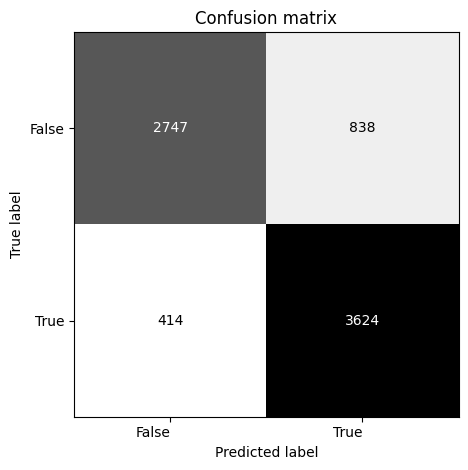

In [113]:
from models.confusion_matrix import *

# use the model to predict test data
predictions = gb_best_est.predict(X_test)
c_matrix = confusion_matrix(y_test.squeeze().values, predictions)
print(predictions, c_matrix)

# Get the unique labels
unique_labels = np.unique(np.concatenate(
    (y_test.squeeze().values, predictions)))

# Draw the unnormalized confusion matrix
draw_confusion_matrix(y_test.squeeze().values, predictions,
                      classes=unique_labels, normalize=False, title='Confusion matrix')

The accuracy of the model is 0.836, precision is 0.812, and recall is 0.898. The model is relatively good since it have lower chance of misclassifying customers who use the offer.

# Conclusion
In this project, we utilized three provided datasets to construct a machine learning model that predicts which customers will utilize the offer. The features incorporated include demographic data such as income, gender, and age, offer metadata like rewards and difficulty, customer membership, and transaction data like membership tenure and the amount spent before receiving the offer. 

We first cleaned up the datasets, then performed exploratory data analysis, and finally merged the three cleaned datasets into one. This was then split into training and testing sets. 

We chose the GradientBoostingClassifier model due to its superior f1 score. The final model achieved an accuracy of 0.836, precision of 0.812, and recall of 0.898.

### Potential Enhancements
- Often, the quality of the data is more crucial than the fine-tuning of the model. In this scenario, having more customer data could potentially lead to a more effective model. 
For instance, one of the most significant features in the model is the amount customers spent before receiving the offer during the test period. If we could access more historical transaction data, we might be able to develop a more accurate model.

- While offers can stimulate sales, they may also lead to a lower margin. In this project, we are predicting if customers will activate the offer. 
An alternative model could predict the amount customers will spend when using the offer. If we could develop such a model, we could target offers to customers who are likely to spend more and thus generate higher margins when activating the offer.

- Some customers will make purchases regardless of whether they have offers, while others are less likely to spend if they don't have any offers. Rather than sending offers to every customer who is likely to spend, we could create different segments and target customers who are less likely to spend without offers.